In [11]:
import __init__
from src.utilities import train_test_validation_splits, \
                            prepare_train_test_val_seqs_by_batches, \
                            tensor2dataloader, load_full_meltome_FLIP_db, \
                            seek_UniprotID_association_Meltome_prots,\
                            download_UniprotID_Alphafold_Structures
import pandas as pd
import numpy as np
    
path_meltome = '../datasets/FLIP/splits/meltome/splits/mixed_split.csv'
complete_meltome_db = '../datasets/FLIP/splits/meltome/full_dataset_sequences.fasta'

full_meltome_db = load_full_meltome_FLIP_db(complete_meltome_db)

splits_meltome = pd.read_csv(path_meltome, sep=',')
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
train, val, test = train_test_validation_splits(splits_meltome)
train = seek_UniprotID_association_Meltome_prots(train, full_meltome_db)
test = seek_UniprotID_association_Meltome_prots(test, full_meltome_db)
val = seek_UniprotID_association_Meltome_prots(val, full_meltome_db)
#print(train)
print("Done")



#ff=full_meltome_db[full_meltome_db['sequence'].isin(train['sequence'])]

Done


In [12]:
from tqdm.auto import tqdm
import torch
from src.ESM2embeddings import ESM2embeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader
from src.NeuralArchitectures import regressionHead
from src.Trainer import Trainer

structuredir = '../datasets/Structures/'
meltome_struct_dir_labels = '../datasets/'


import os 
if not os.listdir(structuredir) and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt'): 
    
    print("Finding structures to proteins via Alphafold/PDB dbs..........") 
    
    download_UniprotID_Alphafold_Structures(train, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_train')
    download_UniprotID_Alphafold_Structures(test, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_test')
    download_UniprotID_Alphafold_Structures(val, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_val')



Structinfo_Meltome_Splits_train = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt', sep='\t')
Structinfo_Meltome_Splits_test = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt', sep='\t')
Structinfo_Meltome_Splits_val = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt', sep='\t')


train = pd.concat([train, Structinfo_Meltome_Splits_train], axis=1).query('Source=="alphafold"')
test = pd.concat([test, Structinfo_Meltome_Splits_test], axis=1).query('Source=="alphafold"')
val = pd.concat([val, Structinfo_Meltome_Splits_val], axis=1).query('Source=="alphafold"')



In [13]:

import torch
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing

import esm
model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.eval()

pt_batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ESM2 = ESM2embeddings(type_embedding = "facebook/esm2_t33_650M_UR50D", device = device, type_tool='FacebookESM2')

dir_pre_generated_embeddings = '../prepro_embeddings/'

path_train= dir_pre_generated_embeddings+'train_set_embeddings_ESM2_with_StructAssociation.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings_ESM2_with_StructAssociation.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings_ESM2_with_StructAssociation.pth'

path_IFtrain= dir_pre_generated_embeddings+'train_set_IFembeddings_ESM2_StructAssociation.pth'
path_IFtest= dir_pre_generated_embeddings+'test_set_IFembeddings_ESM2_StructAssociation.pth'
path_IFval= dir_pre_generated_embeddings+'val_set_IFembeddings_ESM2_StructAssociation.pth'




def embedding_builder_ESM2(ESM2, device, train, test, val, path_train, path_test, path_val):
    if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:

        """batch_train, batch_test, batch_val = prepare_train_test_val_seqs_by_batches(train.sequence.to_list(), 
                                                                                    test.sequence.to_list(), 
                                                                                    val.sequence.to_list(), 
                                                                                    batch_size=2)"""
        print ("Creating Embeddings...")   
        train_embeddings = ESM2.esm2embedding(train, device, layer_index=33) #esm2embedding(train, model, batch_converter, device, layer_index=33)#BERT.embed_dataset(batch_train)
        torch.save(train_embeddings, path_train)
        test_embeddings = ESM2.esm2embedding(test, device, layer_index=33) #esm2embedding(test, model, batch_converter, device, layer_index=33)
        torch.save(test_embeddings, path_test)
        val_embeddings = ESM2.esm2embedding(val, device, layer_index=33) #esm2embedding(val, model, batch_converter, device, layer_index=33)
        torch.save(val_embeddings, path_val)
        print ("Loaded")
    else:
        print ("Loading Premade Embeddings...")
        train_embeddings = torch.load(path_train)
        test_embeddings = torch.load(path_test)
        val_embeddings = torch.load(path_val)
        print ("Loaded")
    return train_embeddings, test_embeddings, val_embeddings


def ESM2_IF_repr(df, model, alphabet):
    embeddings = torch.zeros(len(df),512)#torch.tensor([])
    import os
    import gc
    #if not os.path.isdir(dir_pre_generated_embeddings+'IFembeddings/'):
    #    os.mkdir(dir_pre_generated_embeddings+'IFembeddings/')

    with torch.no_grad():
        for i in tqdm(range(0,len(df))):
            fpath = train.iloc[i].Structure_Alphafold
            structure = esm.inverse_folding.util.load_structure(fpath)
            coords, native_seq = esm.inverse_folding.util.extract_coords_from_structure(structure)

            rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)
            rep = rep.mean(0).reshape(1,-1)
            embeddings[i]=rep
            #embeddings = torch.cat([embeddings, rep])
            #torch.save(rep, dir_pre_generated_embeddings+'IFembeddings/'+str(i)+'.pt' )
            #del rep, structure, coords
            #gc.collect()
            #torch.cuda.empty_cache()
    return embeddings



def IFBuilder_sets(model, alphabet, train, test, val, path_IFtrain, path_IFtest, path_IFval):
    if os.path.isfile(path_IFtrain)==False and os.path.isfile(path_IFtest)==False and os.path.isfile(path_IFval)==False:
        import warnings
        warnings.filterwarnings('ignore')

        IF_embeddings_train = ESM2_IF_repr(train, model, alphabet)
        torch.save(IF_embeddings_train, path_IFtrain)

        IF_embeddings_test = ESM2_IF_repr(test, model, alphabet)
        torch.save(IF_embeddings_test, path_IFtest)

        IF_embeddings_val = ESM2_IF_repr(val, model, alphabet)
        torch.save(IF_embeddings_val, path_IFval)
    else:
        print ("Loading Premade Embeddings...")
        train_embeddings = torch.load(path_IFtrain)
        test_embeddings = torch.load(path_IFtest)
        val_embeddings = torch.load(path_IFval)
        print ("Loaded")
    return train_embeddings, test_embeddings, val_embeddings



/z/home/sgal/miniconda3/envs/thermoPML/lib/python3.9/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [14]:
train_IF_embedding, test_IF_embedding, val_IF_embedding = IFBuilder_sets(model, alphabet, train, test, val, path_IFtrain, path_IFtest, path_IFval)
train_embeddings, test_embeddings, val_embeddings = embedding_builder_ESM2(ESM2, device, train, test, val,  path_train, path_test, path_val)

train_loaderESM2 = tensor2dataloader(train_embeddings, torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderESM2 = tensor2dataloader(test_embeddings, torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderESM2 = tensor2dataloader(val_embeddings, torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)

train_loaderIF = tensor2dataloader(train_IF_embedding, torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderIF = tensor2dataloader(test_IF_embedding, torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderIF = tensor2dataloader(val_IF_embedding, torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)

train_loaderMixed = tensor2dataloader(torch.concat([train_embeddings.to(device), train_IF_embedding.to(device)],dim=1), torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderMixed = tensor2dataloader(torch.concat([test_embeddings.to(device), test_IF_embedding.to(device)],dim=1), torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderMixed = tensor2dataloader(torch.concat([val_embeddings.to(device), val_IF_embedding.to(device)],dim=1), torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)

Loading Premade Embeddings...
Loaded
Loading Premade Embeddings...
Loaded


In [9]:
def generating_results_approaches(FFNNreg, Trner, train_loader, val_loader, test_loader,loss, opt, epochs, device):
    FFNNreg, val_loss = Trner.train_LLMRegresor(train_loader, val_loader, FFNNreg, device, loss, opt, epochs)

    test_set, test_labels = test_loader.dataset.tensors
    loss_test, outcome = Trner.test_model(FFNNreg, test_set, test_labels, loss, device)

    from src.utilities import plot_results

    plot_results( outcome, test_labels)

### For RAW ESM2

In [ ]:
Trainer1 = Trainer()
FFNN_ESM2 = regressionHead(train_embeddings.shape[1::])
optESM2 = torch.optim.Adam(FFNN_ESM2.parameters(), lr=1e-4)
lossESM2= torch.nn.MSELoss()
epochs = 200

generating_results_approaches(FFNN_ESM2, Trainer1, train_loaderESM2, val_loaderESM2, test_loaderESM2,lossESM2, optESM2, epochs, device)

### For Inverse Folding ESM2 Contribution

epoch: 1 loss: 820.647 val loss: 1228.170
epoch: 2 loss: 236.858 val loss: 584.561
epoch: 3 loss: 1561.881 val loss: 273.030
epoch: 4 loss: 28.524 val loss: 153.972
epoch: 5 loss: 112.221 val loss: 120.671
epoch: 6 loss: 11.839 val loss: 114.235
epoch: 7 loss: 8.314 val loss: 113.727
epoch: 8 loss: 103.553 val loss: 113.688
epoch: 9 loss: 1373.292 val loss: 113.810
epoch: 10 loss: 4.011 val loss: 113.623
epoch: 11 loss: 0.955 val loss: 113.846
epoch: 12 loss: 12.245 val loss: 113.788
epoch: 13 loss: 424.906 val loss: 113.585
epoch: 14 loss: 115.266 val loss: 113.590
epoch: 15 loss: 13.787 val loss: 113.564
epoch: 16 loss: 0.069 val loss: 113.452
epoch: 17 loss: 80.510 val loss: 113.583
epoch: 18 loss: 0.505 val loss: 114.021
epoch: 19 loss: 29.081 val loss: 120.066
epoch: 20 loss: 143.778 val loss: 125.916
epoch: 21 loss: 93.694 val loss: 127.893
epoch: 22 loss: 105.241 val loss: 131.498
epoch: 23 loss: 882.947 val loss: 133.266
epoch: 24 loss: 0.008 val loss: 133.827
epoch: 25 loss: 3

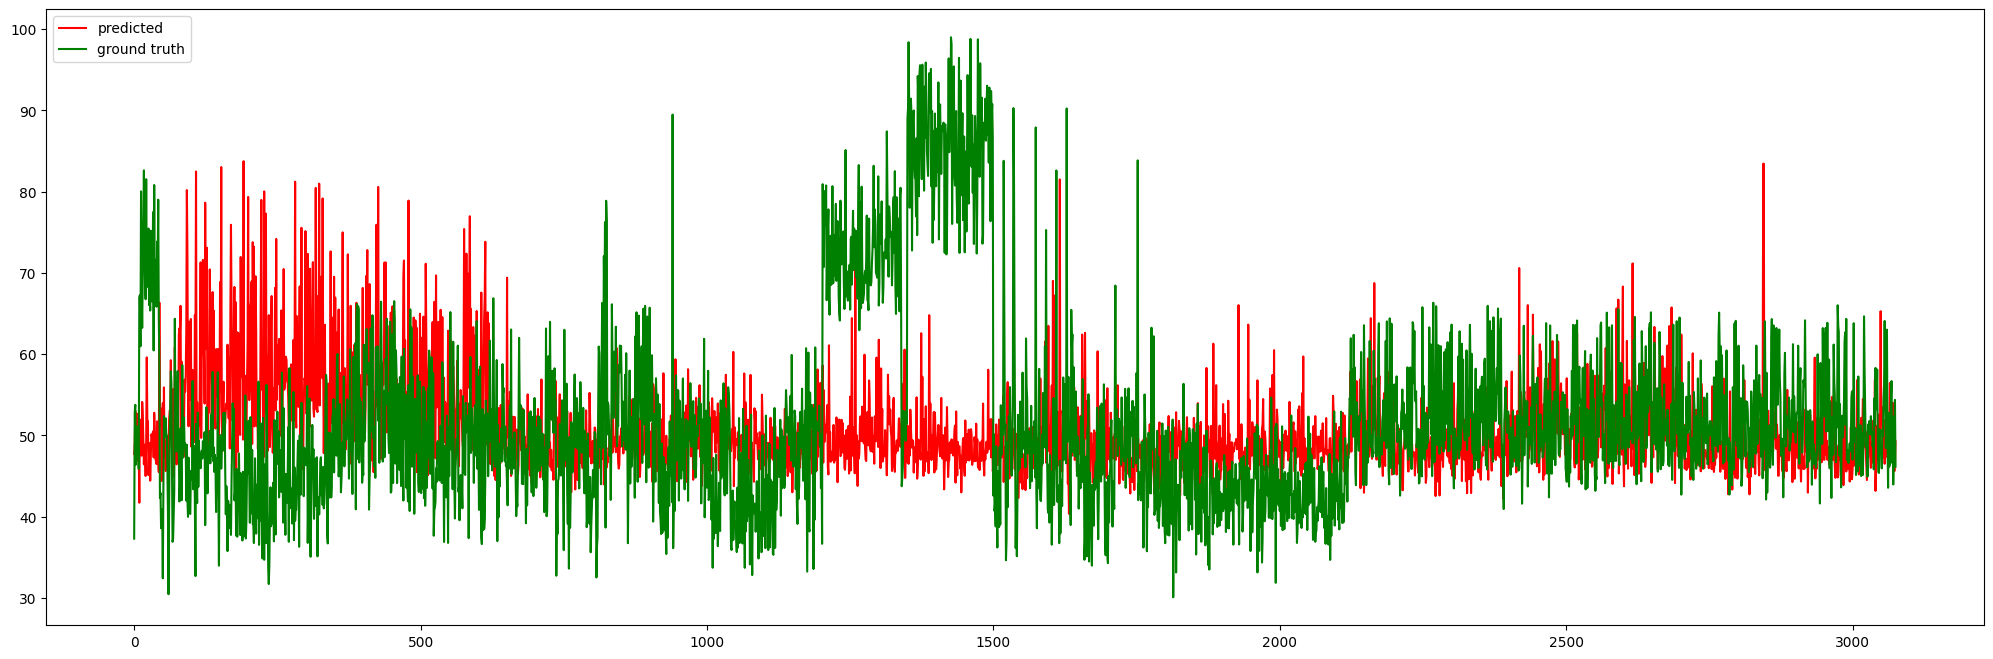

In [17]:
Trainer2 = Trainer()
FFNN_IF = regressionHead(train_IF_embedding.shape[1::] )
optIF = torch.optim.Adam(FFNN_IF.parameters(), lr=1e-4)
lossIF= torch.nn.MSELoss()
epochs = 200

generating_results_approaches(FFNN_IF, Trainer2, train_loaderIF, val_loaderIF, test_loaderIF,lossIF, optIF, epochs, device)

### Combining Raw ESM2 and Inverse Folding Embeddings

In [20]:
Trainer3 = Trainer()
FFNN_Mixed = regressionHead(train_IF_embedding.size(1) + train_embeddings.size(1))
optMixed = torch.optim.Adam(FFNN_Mixed.parameters(), lr=1e-4)
lossMixed= torch.nn.MSELoss()
epochs = 200

generating_results_approaches(FFNN_Mixed, Trainer3, train_loaderMixed, val_loaderMixed, test_loaderMixed,lossMixed, optMixed, epochs, device)